In [1]:
import urllib.request
import shutil
import os
import tarfile
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import torchvision 
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from operator import attrgetter
from functools import partial
from torch.utils.data import DataLoader,default_collate,Dataset
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from diffusers import UNet2DModel
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from diffusers import DDIMScheduler, DDPMScheduler,AutoencoderKL,UNet2DModel
import io
from PIL import Image

2023-07-03 22:57:25.788457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 22:57:27.688322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-03 22:57:27.688484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-03 22:57:27.688497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {def_device}')

# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

Using device: cpu


In [9]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
file_name = 'bedroom.tgz'
data_dir = 'data/bedroom'

In [7]:
# Download the file from `url` and save it locally under `file_name`:
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# Extract the tar file
tar = tarfile.open(file_name, "r:gz")
tar.extractall()
tar.close()

# Delete the tar file
os.remove(file_name)

# Move the images to the right folder
os.rename('bedroom', data_dir)

In [10]:
# Get all image paths recursively
image_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
             image_paths.append(os.path.join(root, file))

# Print the number of images
print(len(image_paths))

303125


In [18]:
class LSUN_Dataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

In [19]:
transforms = T.Compose([T.ToTensor(),T.Resize((256,256),antialias=True)])

ds = LSUN_Dataset(image_paths, transform=transforms)

In [23]:
batch_size = 32

train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

torch.Size([32, 3, 256, 256])


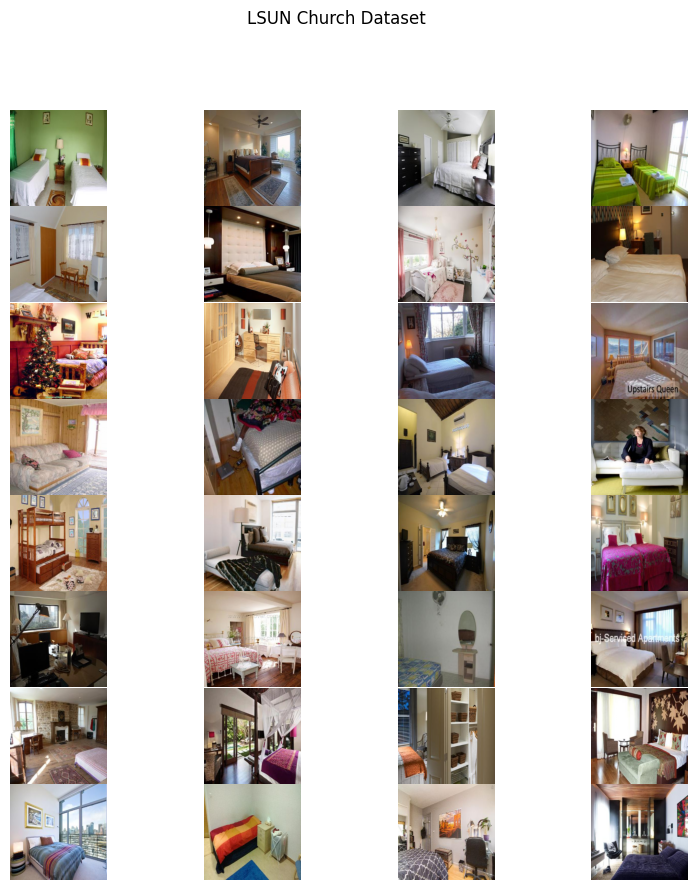

In [26]:
images = next(iter(train_dl))

print(images.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j].clamp(0,1).permute(1,2,0))
        ax[i,j].axis('off')
plt.suptitle('LSUN Church Dataset')
plt.show()

In [3]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(def_device).requires_grad_(False)

In [29]:
encoded_batch = vae.encode(images.to(def_device)).latent_dist.sample()

torch.Size([32, 4, 32, 32])


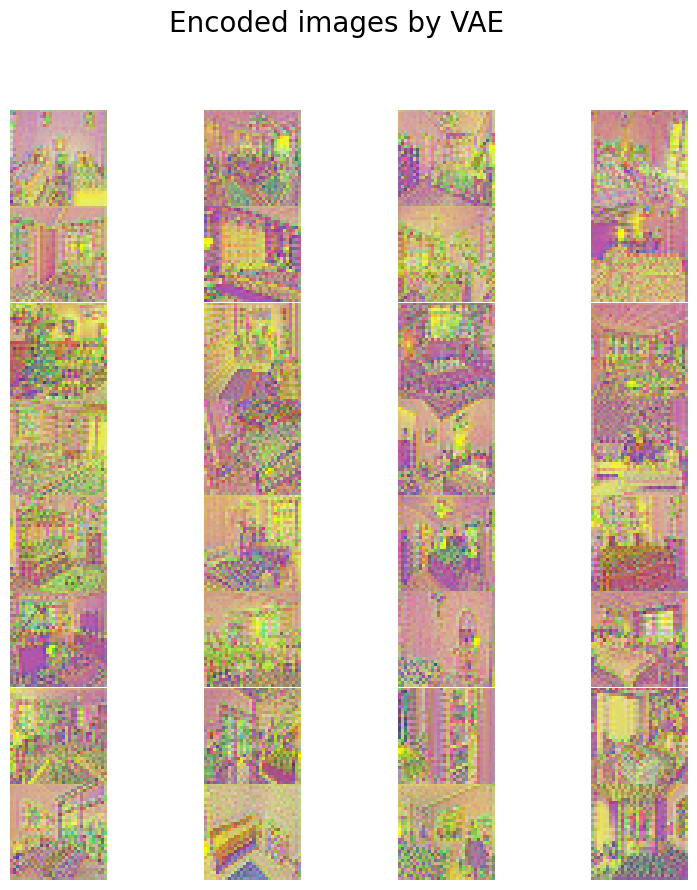

In [30]:
print(encoded_batch.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow((encoded_batch[i*4+j][:3]*0.18125).sigmoid().permute(1,2,0).cpu(),cmap='gray')
        ax[i,j].axis('off')
plt.suptitle('Encoded images by VAE',fontsize=20)
plt.show()

In [31]:
decoded_batch = vae.decode(encoded_batch)['sample']

torch.Size([32, 3, 256, 256])


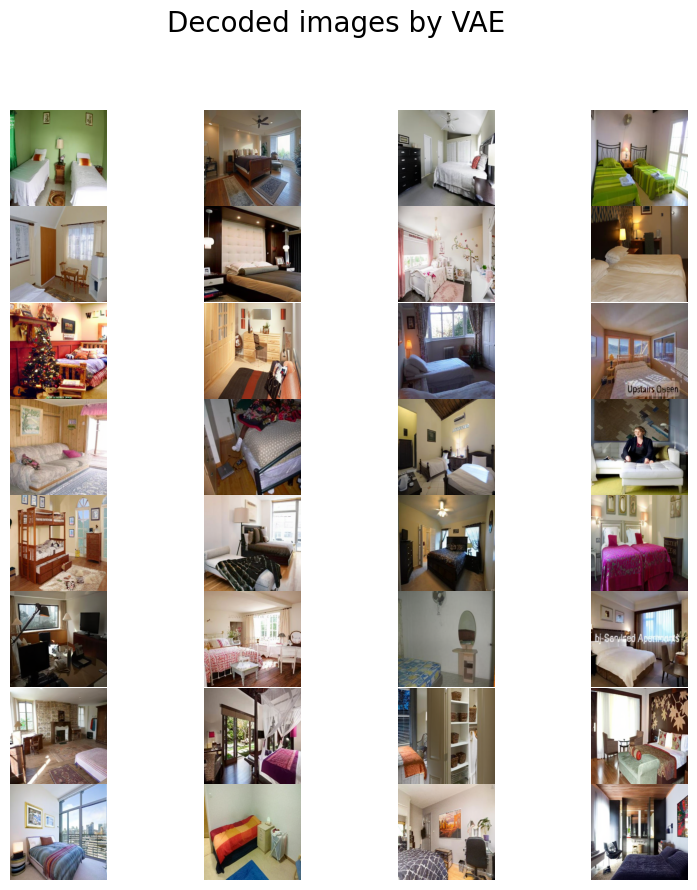

In [32]:
print(decoded_batch.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow(decoded_batch[i*4+j].clamp(0,1).permute(1,2,0).cpu(),cmap='gray')
        ax[i,j].axis('off')
plt.suptitle('Decoded images by VAE',fontsize=20)
plt.show()

In [1]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'latents.dat')

In [ ]:
len(train_dl)*32

In [ ]:
mmshape = (len(train_dl)*32,4,32,32)

In [ ]:
a = np.memmap(filename, np.float32, mode='w+', shape=mmshape)
i = 0
for b in tqdm(train_dl):
    images, labels = b
    n = len(images)
    a[i:i+n] = to_cpu((vae.encode(images.cuda()).latent_dist.sample().detach())*0.18125).numpy()
    i += n
a.flush()
del(a)

In [ ]:
latents = np.memmap(filename, dtype=np.float32, mode='r', shape=mmshape)

In [ ]:
batch_size = 32
train_dl = DataLoader(latents, batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
class DDPM_model(nn.Module):
    def __init__(self, model,beta_min = 0.00085, beta_max = 0.012, n_steps = 1000):
        super().__init__()
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = self.alpha.cumprod(dim=0)
        self.sigma = self.beta.sqrt()

    def add_noise(self, x_0):
        device = x_0.device
        n = len(x_0)
        timesteps = torch.randint(0, self.n_steps, (n,), device=device)
        alphabar_t = self.alphabar.to(device)[timesteps].reshape(-1, 1, 1, 1)
        noise = torch.randn_like(x_0, device=device)
        x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
        return (x_t, timesteps.to(device)), noise

    def forward(self, x):
        return self.model.forward(*x).sample

In [5]:
unet_model = UNet2DModel(in_channels=4, out_channels=4,block_out_channels=(128,256,384,512))
model = DDPM_model(unet_model)

In [ ]:
epochs = 15
lr = 0.005
opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [ ]:
def fit(model,train_dl,loss_func,epochs,opt,sched):
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        losses = []
        model.train()
        for xb,_ in train_dl:
            opt.zero_grad()
            xb = to_device(xb)
            (x_t, timesteps), noise = model.add_noise(xb)
            (x_t, timesteps) = to_device((x_t, timesteps))
            noise = to_device(noise)
            with torch.cuda.amp.autocast(dtype=torch.float16):
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
            losses.append(loss.item() * len(xb))
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")

In [ ]:
fit(model.to(def_device),train_dl,F.mse_loss,epochs,opt,sched)

In [ ]:
model = model.cpu()
torch.save(model,"latent_diffusion.pt")
torch.save(model.state_dict(),"latent_diffusion_state_dict.pth")
torch.save(model.model.state_dict(),"latent_diffusion_unet_state_dict.pth")

In [6]:
model = DDPM_model(unet_model)
model.load_state_dict(torch.load("latent_diffusion_LSUN_bedrooms.pth",map_location=torch.device('cpu')))
model = model.to(def_device).eval()
vae = vae.to('cpu')

In [7]:
def sample(sched,model,sz = (16,4,32,32)):
    preds = []
    device = next(model.parameters()).device
    x_t = torch.randn(sz).to(device)
    for t in tqdm(sched.timesteps,total=sched.num_inference_steps):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        with torch.no_grad(): noise = model((x_t, t_batch))
        x_t = sched.step(noise, t, x_t).prev_sample
        preds.append(x_t.float().cpu())
    return preds

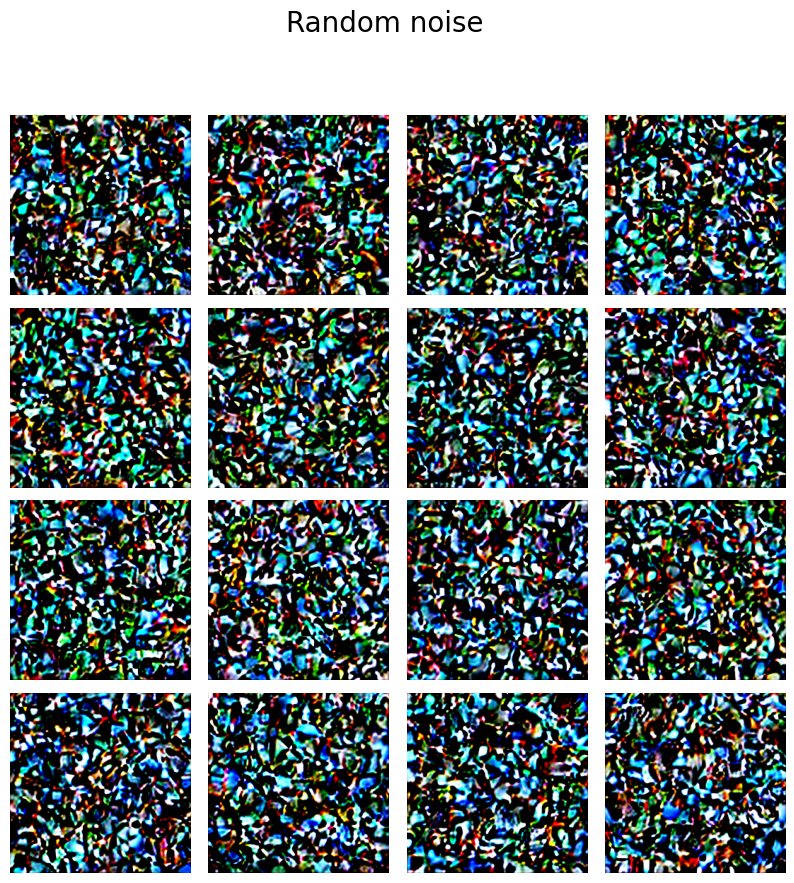

In [10]:
random_noise = torch.randn(16,4,32,32)*5.489
decoded_random_noise = vae.decode(random_noise)['sample']

fig, ax = plt.subplots(4,4,figsize=(10,10),gridspec_kw = {'wspace':0.1, 'hspace':0})
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(decoded_random_noise[i*4+j].clamp(0,1).permute(1,2,0))
        ax[i,j].axis('off')
plt.suptitle('Random noise',fontsize=20)
plt.show()

100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s]


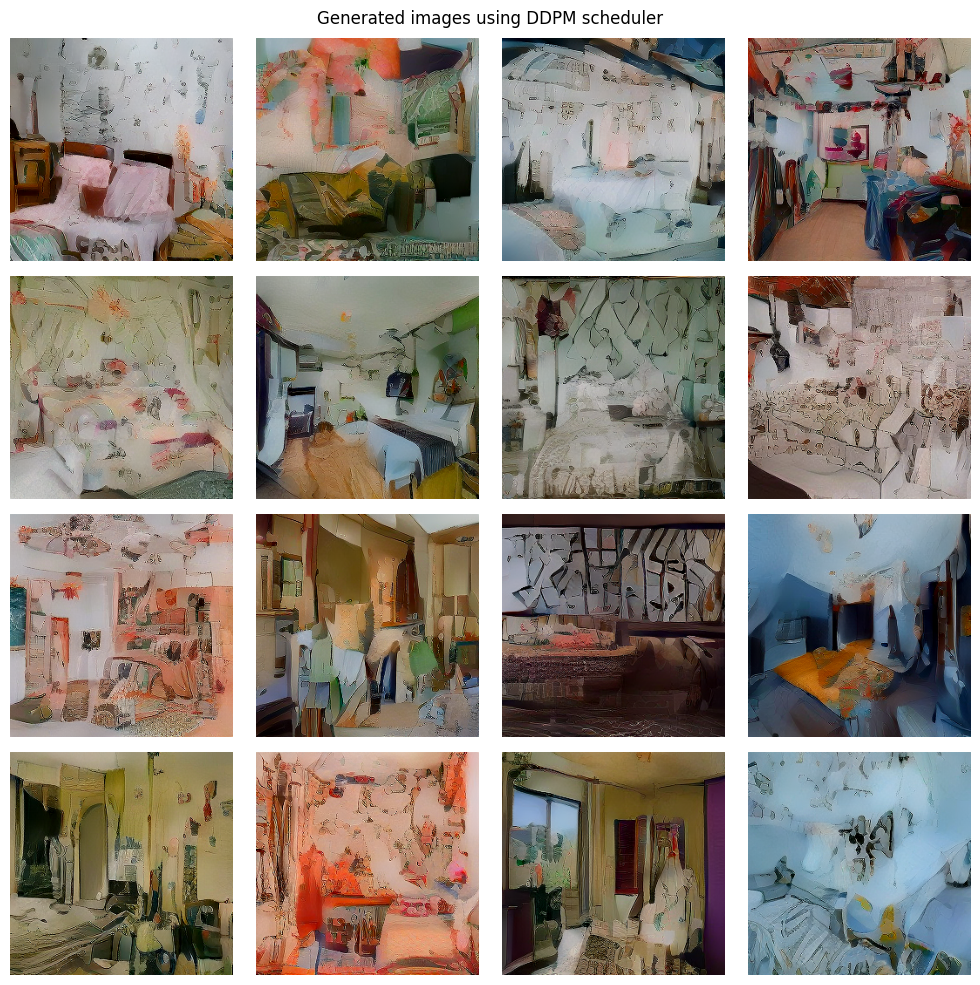

In [8]:
sched = DDPMScheduler(beta_start = 0.00085, beta_end = 0.012)
preds = sample(sched,model)
preds[-1] = preds[-1]*5.489
preds[-1] = vae.decode(preds[-1])['sample']

plt.figure(figsize=(10, 10))
plt.suptitle("Generated images using DDPM scheduler")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((preds[-1][i].permute(1,2,0)).clamp(0,1))
    plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 333/333 [04:26<00:00,  1.25it/s]


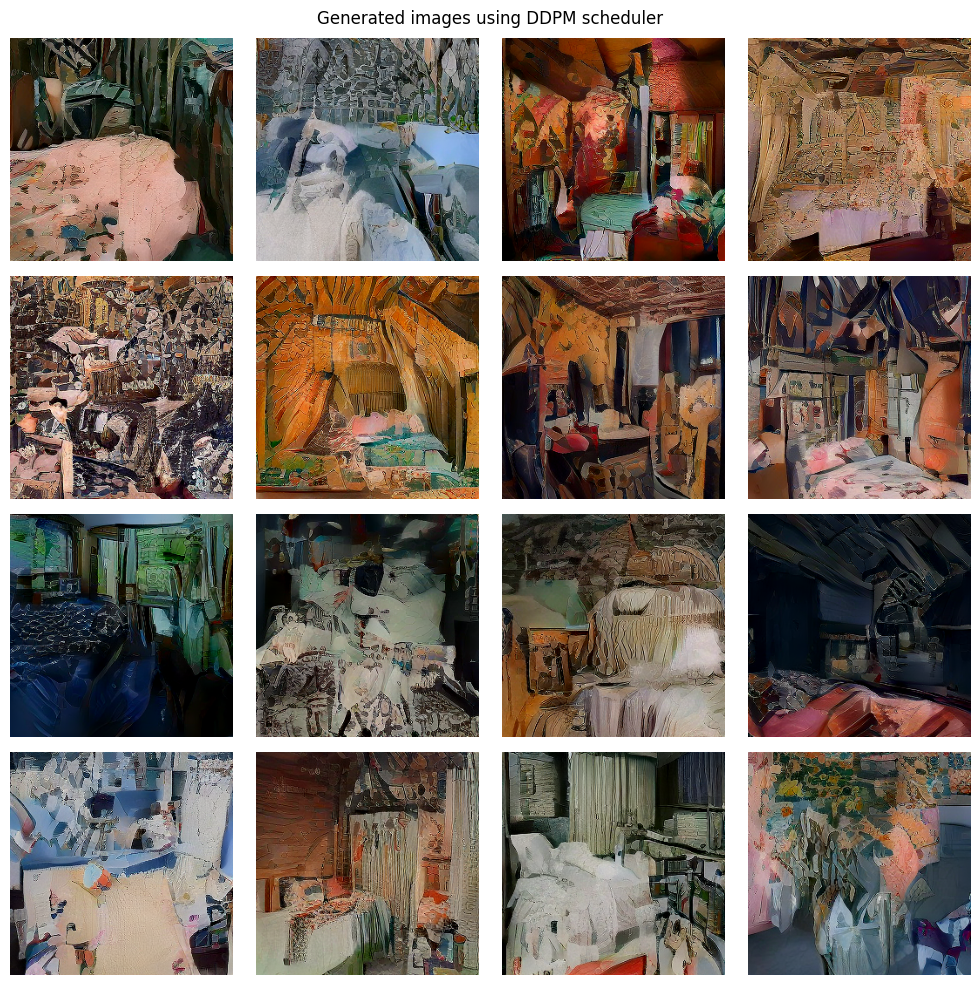

In [9]:
sched = DDIMScheduler(beta_start = 0.00085, beta_end = 0.012)
sched.set_timesteps(333)
preds = sample(sched,model)
preds[-1] = preds[-1]*5.489
preds[-1] = vae.decode(preds[-1])['sample']

plt.figure(figsize=(10, 10))
plt.suptitle("Generated images using DDPM scheduler")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((preds[-1][i].permute(1,2,0)).clamp(0,1))
    plt.axis('off')
plt.tight_layout()
plt.show()